# PMF: Analysis of expectation and variance estimators

The notebook illustrates bias and variance of the estimators used to match Poisson Matrix Factorization priors in pmf_sgd_optimization.ipynb

## Setup 


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import tensorflow as tf
#tf.enable_eager_execution()
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
#from tensorflow.contrib.distributions import softplus_inverse
#tfe = tf.contrib.eager

In [3]:
tf.executing_eagerly(), tf.__version__, tfp.__version__

(True, '2.1.0', '0.9.0')

In [4]:
import time
import numpy as np
import pandas as pd

In [5]:
from aux import *

In [6]:
import matplotlib
from matplotlib import pyplot as plt
from aux_plt import *

# Configuration

In [7]:
args = parse_script_args()

parsing: <-f>


In [8]:
SEED = args.get("SEED", 123)

In [9]:
K = args.get("K", 25) # factorization dimensions

In [10]:
DESCRIPTION = dict2str(globals()).replace("NSAMPLES", "S").replace("DESIRED_", "").replace("EXPECTATION", "E").replace("VARIANCE", "V").replace("TRAINABLE", "TT")
print("DESCRIPTION: %s" % DESCRIPTION)

ID = str(args.get("ID", DESCRIPTION))

DESCRIPTION: K=25 SEED=123


# Expectation & variance evaluation

In [11]:
from pmf_model import create_moments_estimator


theoretical_moments = create_moments_estimator(K=K, ESTIMATOR_NO=-1, N=1, M=1)
empirical_moments = create_moments_estimator(K=K, ESTIMATOR_NO=0, N=1, M=1)

print("empirical_moments := %s" % empirical_moments.__name__)

empirical_moments := empirical_moments_fully_decoupled


In [12]:
def empirical_moments_mean_std(a, b, c, d, nsamples_latent, nsamples_output, nruns):
    """Returns means and stds of expectation and variance."""
    ev = []
    a = tf.Variable(a, dtype=tf.float64)
    b = tf.Variable(b, dtype=tf.float64)
    c = tf.Variable(c, dtype=tf.float64)
    d = tf.Variable(d, dtype=tf.float64)
    for r in range(nruns):
      #print("%i/%i" % (r, nruns))
      ev.append( empirical_moments(a, b, c, d, nsamples_latent, nsamples_output) )
    ev = np.array(ev)
    e_mean, var_mean = ev.mean(0);
    e_std, var_std = ev.std(0)
    return (e_mean, e_std), (var_mean, var_std)

# Analysis of number of samples 

In [13]:
ABCD_CFGS = [ (10, 1, 10, 1), (10,2,10,2), (0.001, 0.01, 0.01, 0.1),(0.1, 1, 0.1, 1), 
              (0.1, 0.1, 0.1, 0.1), (1.0, 1.0, 0.1, 0.1), (1000.0, 1000.0, 1000.0, 1000.0),]
LABELS = ["A","B","C","D","E","F","G"]

LABEL2CFG = dict(zip(LABELS,ABCD_CFGS))

NSAMPLES_CFGS = [(100,100),(1000,10),(10,1000)]

nruns = 1000

In [14]:
for a,b,c,d in ABCD_CFGS:
    e, v = theoretical_moments(a,b,c,d)
    print("a=%.3f\tb=%.3f\tc=%.3f\td=%.3f\t=> E=%.2f \tV=%.2f" % (a,b,c,d,e,v))

a=10.000	b=1.000	c=10.000	d=1.000	=> E=2500.00 	V=55000.00
a=10.000	b=2.000	c=10.000	d=2.000	=> E=625.00 	V=3906.25
a=0.001	b=0.010	c=0.010	d=0.100	=> E=0.25 	V=253.00
a=0.100	b=1.000	c=0.100	d=1.000	=> E=0.25 	V=0.55
a=0.100	b=0.100	c=0.100	d=0.100	=> E=25.00 	V=3025.00
a=1.000	b=1.000	c=0.100	d=0.100	=> E=25.00 	V=550.00
a=1000.000	b=1000.000	c=1000.000	d=1000.000	=> E=25.00 	V=25.05


In [15]:
tf.random.set_seed(SEED)
np.random.seed(SEED)
results = []
for a,b,c,d in ABCD_CFGS:
    for nl, no in NSAMPLES_CFGS:
        start = time.time()
        (e_mean, e_std), (var_mean, var_std) = empirical_moments_mean_std(a,b,c,d, nl, no, nruns)
        r = (a,b,c,d,nl,no, e_mean, e_std, var_mean, var_std, ((time.time()-start)/nruns) )
        print("a=%.2f\tb=%.2f\tc=%.2f\td=%.2f\tnl=%i no=%i => E=%.2f +/- %.2f \tV=%.2f +/- %.2f (%.2fs)" % r)
        results.append(r)

a=10.00	b=1.00	c=10.00	d=1.00	nl=100 no=100 => E=2499.83 +/- 23.15 	V=54750.87 +/- 161514.53 (0.01s)
a=10.00	b=1.00	c=10.00	d=1.00	nl=1000 no=10 => E=2500.44 +/- 7.29 	V=54497.97 +/- 51442.51 (0.02s)
a=10.00	b=1.00	c=10.00	d=1.00	nl=10 no=1000 => E=2501.72 +/- 70.49 	V=68000.31 +/- 492757.25 (0.01s)
a=10.00	b=2.00	c=10.00	d=2.00	nl=100 no=100 => E=625.01 +/- 5.82 	V=4651.16 +/- 10143.96 (0.01s)
a=10.00	b=2.00	c=10.00	d=2.00	nl=1000 no=10 => E=625.07 +/- 1.80 	V=3858.57 +/- 3320.98 (0.03s)
a=10.00	b=2.00	c=10.00	d=2.00	nl=10 no=1000 => E=624.24 +/- 17.75 	V=2700.05 +/- 32320.39 (0.01s)
a=0.00	b=0.01	c=0.01	d=0.10	nl=100 no=100 => E=0.20 +/- 1.14 	V=82.64 +/- 835.59 (0.01s)
a=0.00	b=0.01	c=0.01	d=0.10	nl=1000 no=10 => E=0.25 +/- 0.46 	V=160.80 +/- 1088.81 (0.02s)
a=0.00	b=0.01	c=0.01	d=0.10	nl=10 no=1000 => E=0.17 +/- 2.27 	V=132.95 +/- 8500.37 (0.00s)
a=0.10	b=1.00	c=0.10	d=1.00	nl=100 no=100 => E=0.25 +/- 0.05 	V=0.56 +/- 0.39 (0.01s)
a=0.10	b=1.00	c=0.10	d=1.00	nl=1000 no=10 => E=0.25

In [16]:
path = "RESULTS/nsamples_analysis_%s_%s.csv" % (K, nruns)
print("path = %s" % path)
pd.DataFrame(results).to_csv(path, index=False, header=False)
df = pd.read_csv(path, header=None).rename(columns=dict(enumerate(["a", "b", "c", "d", "nl", "no", "Em", "Es", "Vm", "Vs", "time"])))
df

path = RESULTS/nsamples_analysis_25_1000.csv


,a,b,c,d,nl,no,Em,Es,Vm,Vs,time
0,10.000,1.00,10.00,1.0,100,100,2499.827486,23.148860,54750.869583,161514.534783,0.007367
1,10.000,1.00,10.00,1.0,1000,10,2500.435710,7.288014,54497.971288,51442.509271,0.017813
2,10.000,1.00,10.00,1.0,10,1000,2501.717178,70.489039,68000.311104,492757.247793,0.006772
3,10.000,2.00,10.00,2.0,100,100,625.007992,5.822493,4651.163930,10143.963276,0.007581
4,10.000,2.00,10.00,2.0,1000,10,625.070476,1.800209,3858.566589,3320.979347,0.025922
5,10.000,2.00,10.00,2.0,10,1000,624.241588,17.752174,2700.045504,32320.389505,0.006303
6,0.001,0.01,0.01,0.1,100,100,0.203531,1.135151,82.642368,835.587793,0.007328
7,0.001,0.01,0.01,0.1,1000,10,0.251504,0.455077,160.799738,1088.810950,0.024090
8,0.001,0.01,0.01,0.1,10,1000,0.171245,2.271866,132.947937,8500.371151,0.004447
9,0.100,1.00,0.10,1.0,100,100,0.248745,0.053279,0.559495,0.390089,0.005496


# Plotting

In [17]:
import warnings
warnings.filterwarnings("ignore")

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


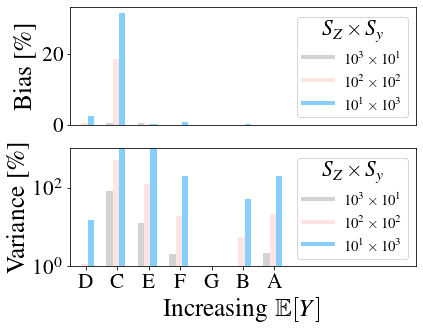

In [18]:
labels = "DCEFGBA"
MEANCOL, STDCOL = "Em", "Es"

start_plotting(cmbright=False, font_size=17*1.5)

ax1 = plt.subplot(211)  
for i, LABEL in enumerate(labels):
  a,b,c,d = LABEL2CFG[LABEL]    
  shift = i*4    
    
  d11 = df[(df.a==a)&(df.b==b)&(df.c==c)&(df.d==d)]
  exp, var = theoretical_moments(a,b,c,d)
  Z, LABEL = 1.0/exp * 100.0, r"Bias [\%]"
  #Z, LABEL = 1.0, "Bias"    
             
  d1 = d11[(df.nl==10)&(df.no==1000)]
  xs = list(np.arange(len(d1))+shift+1.6)
  plt.bar(xs, abs(d1[MEANCOL]-exp) * Z, color="lightskyblue", width=0.8, align="center")

  d1 = d11[(df.nl==100)&(df.no==100)]
  xs = list(np.arange(len(d1))+shift+0.8)
  plt.bar(xs, abs(d1[MEANCOL]-exp) * Z, color="mistyrose", width=0.8, align="center")        
        
  d1 = d11[(df.nl==1000)&(df.no==10)]
  xs = list(np.arange(len(d1))+shift)
  plt.bar(xs, abs(d1[MEANCOL]-exp) * Z, color="lightgrey", width=0.8, align="center")

plt.xticks([],[])
plt.ylabel(LABEL)
plt.axhline(0.0, color="k", zorder=-1, lw=1, ls="--")
#plt.yscale("log")
#plt.ylim(0.1, 100000)
#plt.ylim(0.1, 10)
plt.xlim(-1, 43)
#plt.yscale("log")

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color="lightgrey", lw=4),
                Line2D([0], [0], color="mistyrose", lw=4),
                Line2D([0], [0], color="lightskyblue", lw=4),]
plt.gca().legend(custom_lines, [r"$10^3 \times 10^1$", r"$10^2 \times 10^2$", r"$10^1 \times 10^3$"], 
                 title=r"$S_{Z} \times S_y$", fontsize=15, loc=4)

ax1 = plt.subplot(212)  
for i, LABEL in enumerate(labels):
  a,b,c,d = LABEL2CFG[LABEL]    
  shift = i*4    
    
  d11 = df[(df.a==a)&(df.b==b)&(df.c==c)&(df.d==d)]
  exp, var = theoretical_moments(a,b,c,d)
  Z, LABEL = 1.0/exp * 100.0, r"Variance [\%]"
  #Z, LABEL = 1.0, "Variance"
    
     
  d1 = d11[(df.nl==10)&(df.no==1000)]
  xs = list(np.arange(len(d1))+shift+1.6)
  plt.bar(xs, d1[STDCOL]**2 * Z, color="lightskyblue", width=0.8, align="center")

  d1 = d11[(df.nl==100)&(df.no==100)]
  xs = list(np.arange(len(d1))+shift+0.8)
  plt.bar(xs, d1[STDCOL]**2 * Z, color="mistyrose", width=0.8, align="center")

  d1 = d11[(df.nl==1000)&(df.no==10)]
  xs = list(np.arange(len(d1))+shift)
  plt.bar(xs, d1[STDCOL]**2 * Z, color="lightgrey", width=0.8, align="center")


plt.xticks(np.arange(0, 4*len(labels), 4)+1, labels)  
plt.ylabel(LABEL)
plt.xlabel(r"Increasing $\mathbb{E}[Y]$")
plt.axhline(0.0, color="k", zorder=-1, lw=1, ls="--")
plt.yscale("log")
#plt.ylim(0.001, 2000.0)
plt.ylim(1, 1000.0)
plt.xlim(-1, 43)


from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color="lightgrey", lw=4),
                Line2D([0], [0], color="mistyrose", lw=4),
                Line2D([0], [0], color="lightskyblue", lw=4),]
plt.gca().legend(custom_lines, [r"$10^3 \times 10^1$", r"$10^2 \times 10^2$", r"$10^1 \times 10^3$"], 
                 title=r"$S_{Z} \times S_y$", fontsize=15, loc=4)

plt.subplots_adjust(left=0.2, right=0.95, top=0.95, bottom=0.2)    
plt.savefig("RESULTS/nsamples_e.pdf")
plt.show()

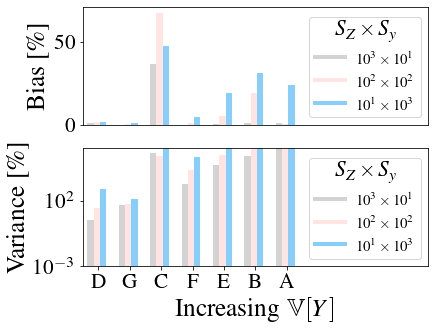

In [19]:
labels = "DGCFEBA"
MEANCOL, STDCOL = "Vm", "Vs"


start_plotting(cmbright=False, font_size=17*1.5)

ax1 = plt.subplot(211)  
for i, LABEL in enumerate(labels):
  a,b,c,d = LABEL2CFG[LABEL]    
  shift = i*4    
      

  d11 = df[(df.a==a)&(df.b==b)&(df.c==c)&(df.d==d)]
  exp, var = theoretical_moments(a,b,c,d)
  Z, LABEL = 1.0/var * 100.0, r"Bias [\%]"
  #Z, LABEL = 1.0, "Bias"
             
  d1 = d11[(df.nl==10)&(df.no==1000)]
  xs = list(np.arange(len(d1))+shift+1.6)
  plt.bar(xs, abs(d1[MEANCOL]-var)*Z, color="lightskyblue", width=0.8, align="center")

  d1 = d11[(df.nl==100)&(df.no==100)]
  xs = list(np.arange(len(d1))+shift+0.8)
  plt.bar(xs, abs(d1[MEANCOL]-var)*Z, color="mistyrose", width=0.8, align="center")        
        
  d1 = d11[(df.nl==1000)&(df.no==10)]
  xs = list(np.arange(len(d1))+shift)
  plt.bar(xs, abs(d1[MEANCOL]-var)*Z, color="lightgrey", width=0.8, align="center")

plt.xticks([],[])
plt.ylabel(LABEL)
plt.axhline(0.0, color="k", zorder=-1, lw=1, ls="--")
#plt.yscale("log")
#plt.ylim(0.1, 100000)
plt.xlim(-1, 43)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color="lightgrey", lw=4),
                Line2D([0], [0], color="mistyrose", lw=4),
                Line2D([0], [0], color="lightskyblue", lw=4),]
plt.gca().legend(custom_lines, [r"$10^3 \times 10^1$", r"$10^2 \times 10^2$", r"$10^1 \times 10^3$"], 
                 title=r"$S_{Z} \times S_y$", fontsize=15, loc=4)

ax1 = plt.subplot(212)  
for i, LABEL in enumerate(labels):
  a,b,c,d = LABEL2CFG[LABEL]    
  shift = i*4    
    
  d11 = df[(df.a==a)&(df.b==b)&(df.c==c)&(df.d==d)]
  exp, var = theoretical_moments(a,b,c,d)
  Z, LABEL = 1.0/var * 100.0, r"Variance [\%]"
  #Z, LABEL = 1.0, "Variance"    
     
  d1 = d11[(df.nl==10)&(df.no==1000)]
  xs = list(np.arange(len(d1))+shift+1.6)
  plt.bar(xs, d1[STDCOL]**2*Z, color="lightskyblue", width=0.8, align="center")

  d1 = d11[(df.nl==100)&(df.no==100)]
  xs = list(np.arange(len(d1))+shift+0.8)
  plt.bar(xs, d1[STDCOL]**2*Z, color="mistyrose", width=0.8, align="center")

  d1 = d11[(df.nl==1000)&(df.no==10)]
  xs = list(np.arange(len(d1))+shift)
  plt.bar(xs, d1[STDCOL]**2*Z, color="lightgrey", width=0.8, align="center")


plt.xticks(np.arange(0, 4*len(labels), 4)+1, labels)  
plt.ylabel(LABEL)
plt.xlabel(r"Increasing $\mathbb{V}[Y]$")
plt.axhline(0.0, color="k", zorder=-1, lw=1, ls="--")
plt.yscale("log")
plt.ylim(0.001, 1e6)
plt.xlim(-1, 43)


from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color="lightgrey", lw=4),
                Line2D([0], [0], color="mistyrose", lw=4),
                Line2D([0], [0], color="lightskyblue", lw=4),]
plt.gca().legend(custom_lines, [r"$10^3 \times 10^1$", r"$10^2 \times 10^2$", r"$10^1 \times 10^3$"], 
                 title=r"$S_{Z} \times S_y$", fontsize=15, loc=4)

plt.subplots_adjust(left=0.2, right=0.95, top=0.95, bottom=0.2)    
plt.savefig("RESULTS/nsamples_v.pdf")
plt.show()